In [1]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
import networkx as nx
import matplotlib.pyplot as plt
import hierarchical as hrc
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda:0")
tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
g = torch.load('FILE_PATH').to(device) # 'FILE_PATH' in store_matrices.py

vocab_dict = tokenizer.get_vocab()
vocab_list = [None] * (max(vocab_dict.values()) + 1)
for word, index in vocab_dict.items():
    vocab_list[index] = word

In [3]:
with open("data/Romance_full_nouns.json", "r", encoding="utf-8") as f:
    data = json.load(f)

categories = ["Spanish", "French", "Portuguese", "Italian"] ###!!!!
r_token, r_ind, r_g = hrc.get_animal_category(data, categories,  vocab_dict, g)

dirs = {k: hrc.estimate_cat_dir(v, g, vocab_dict) for k, v in r_token.items()}

all_r_tokens = [a for k, v in r_token.items() for a in v]
dirs.update({'Romance': hrc.estimate_cat_dir(all_r_tokens, g, vocab_dict)})
r_token.update({'Romance': all_r_tokens})

with open("data/Germanic_nouns.json", "r", encoding="utf-8") as f:
    data = json.load(f)

germanic_token = []
vocab_set = set(vocab_dict.keys())
lemmas = data["German"]
for w in lemmas:
    germanic_token.extend(hrc.noun_to_gemma_vocab_elements(w, vocab_set))

dirs_germanic = hrc.estimate_cat_dir(germanic_token, g, vocab_dict)

In [4]:
"""
plotting functions
"""

import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as mpatches

sns.set_theme(
    context="paper",
    style="white",  # 'whitegrid', 'dark', 'darkgrid', ...
    palette="colorblind",
    font="DejaVu Sans",  # 'serif'
    font_scale=1.75,  # 1.75, 2, ...
)

def cos_heatmap(mats, titles = None, figsize = (19, 8),
                labels = None,
                cmap=None, use_absvals=False, save_as = None):
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, len(mats), wspace=0)

    vmin = -0.001 if use_absvals else -1.001
    vmax = 1.001

    if cmap is None:
        # darker defaults
        cmap = "mako" if use_absvals else "icefire"

    ims = []
    for i in range(len(mats)):
        ax = plt.subplot(gs[0, i])
        im = ax.imshow(mats[i], aspect = 'equal', cmap=cmap,
                       vmin=vmin, vmax=vmax, interpolation='nearest')
        ims.append(im)
        if labels != None:
            ytick = list(range(len(labels)))
            ax.set_yticks(ytick)
            ax.set_xticks(ytick)
            if i == 0:
                ax.set_yticklabels(labels)
                # ax.set_xticklabels(labels, rotation = 60, ha = "right")
                ax.set_xticklabels([])
            else:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
            
        if titles != None:
            ax.set_title(titles[i])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(ims[-1], cax=cax, orientation='vertical')

    plt.tight_layout()
    if save_as != None:
        plt.savefig(f"figures/{save_as}.pdf", bbox_inches='tight')
    plt.show()

def proj_2d(dir1, dir2, unembed, vocab_list, ax,
              added_inds=None,
              normalize = True,
              orthogonal=False, k=10, fontsize=10,
              alpha=0.2, s=0.5,
              target_alpha = 0.9, target_s = 2,
              xlim = None,
              ylim = None,
              draw_arrows = False,
              arrow1_name = None,
              arrow2_name = None,
              right_topk = True,
              left_topk = True,
              top_topk = True,
              bottom_topk = True,
              xlabel="dir1",
              ylabel="dir2",
              title="2D projection plot"):
    original_dir1 = dir1
    original_dir2 = dir2
    
    if normalize:
        dir1 = dir1 / dir1.norm()
        dir2 = dir2 / dir2.norm()
    if orthogonal:
        dir1 = dir1 / dir1.norm()
        dir2 = dir2 - (dir2 @ dir1) * dir1
        dir2 = dir2 / dir2.norm()

        arrow1 = [(original_dir1 @ dir1).cpu().numpy(), 0]
        arrow2 = [(original_dir2 @ dir1).cpu().numpy(), (original_dir2 @ dir2).cpu().numpy()]

    proj1 = unembed @ dir1
    proj2 = unembed @ dir2
    
    ax.scatter(proj1.cpu().numpy(), proj2.cpu().numpy(),
               alpha=alpha, color="gray", s=s)
    
    def _add_labels_for_largest(proj, largest):
        indices = torch.topk(proj, k=k, largest=largest).indices
        for idx in indices:
            if "$" not in vocab_list[idx]:
                ax.text(proj1[idx], proj2[idx], vocab_list[idx], fontsize=fontsize)
    
    if right_topk:
        _add_labels_for_largest(proj1, largest=True)
    if left_topk:
        _add_labels_for_largest(proj1, largest=False)
    if top_topk:
        _add_labels_for_largest(proj2, largest=True)
    if bottom_topk:
        _add_labels_for_largest(proj2, largest=False)

    if added_inds:
        colors = iter(["b", "r", "green", "orange",
                       "skyblue", "pink",  "yellowgreen", "orange", "yellow",
                       "brown", "cyan", "olive", "purple", "lime"])
        legend_handles = []
        for label, indices in added_inds.items():
            color = next(colors)
            word_add = [vocab_list[i] for i in indices]
            for word, idx in zip(word_add, indices):
                # ax.text(proj1[idx], proj2[idx], word,
                #         fontsize=fontsize, bbox=dict(facecolor=color, alpha=0.2))
                ax.scatter(proj1[idx].cpu().numpy(), proj2[idx].cpu().numpy(),
                           alpha=target_alpha, color=color, s=target_s)
            # Create a patch for the legend
            legend_handles.append(mpatches.Patch(color=color, label=label))
        
        ax.legend(handles=legend_handles, loc = 'lower left', prop={'size': 20})


    if xlim is not None:
        ax.set_xlim(xlim)
        ax.hlines(0, xmax=xlim[1], xmin=xlim[0],
                  colors="black", alpha=0.3, linestyles="dashed")
    else:
        ax.hlines(0, xmax=proj1.max().cpu().numpy(), xmin=proj1.min().cpu().numpy(),
              colors="black", alpha=0.3, linestyles="dashed")
    if ylim is not None:
        ax.set_ylim(ylim)
        ax.vlines(0, ymax=ylim[1], ymin=ylim[0],
                  colors="black", alpha=0.3, linestyles="dashed")
    else:
        ax.vlines(0, ymax=proj2.max().cpu().numpy(), ymin=proj2.min().cpu().numpy(),
              colors="black", alpha=0.3, linestyles="dashed")
        
    if draw_arrows:
        ax.arrow(0, 0, arrow1[0], arrow1[1], head_width=0.5, head_length=0.5,
                 width=0.1, fc='blue', ec='blue',
                 linestyle='dashed',  alpha = 0.6, length_includes_head = True)
        if arrow1_name!=None:
            ax.text(arrow1[0]/2+2.5, arrow1[1]/2+0.5, arrow1_name, fontsize=fontsize,
                    bbox=dict(facecolor='blue', alpha=0.2))
        ax.arrow(0, 0, arrow2[0], arrow2[1], head_width=0.5, head_length=0.5,
                 width=0.1,  fc='red', ec='red',
                 linestyle='dashed',  alpha = 0.6, length_includes_head = True)
        if arrow2_name!=None:
            ax.text(arrow2[0]/2-1.5, arrow2[1]/2+1.5, arrow2_name, fontsize=fontsize,
                    bbox=dict(facecolor='red', alpha=0.2))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


def proj_2d_single_diff(higher, subcat1, subcat2, unembed, vocab_list, ax,
                        added_inds=None,
                        normalize = True,
                        orthogonal=False, k=10, fontsize=10,
                        alpha=0.2, s=0.5,
                        target_alpha = 0.9, target_s = 2,
                        xlim = None,
                        ylim = None,
                        draw_arrows = False,
                        arrow1_name = None,
                        arrow2_name = None,
                        right_topk = True,
                        left_topk = True,
                        top_topk = True,
                        bottom_topk = True,
                        xlabel="dir1",
                        ylabel="dir2",
                        title="2D projection plot"):
    dir1 = higher
    dir2 = subcat2 - subcat1

    original_higher = higher
    original_subcat1 = subcat1
    original_subcat2 = subcat2
    original_dir1 = dir1
    original_dir2 = dir2
    
    if normalize:
        dir1 = dir1 / dir1.norm()
        dir2 = dir2 / dir2.norm()
    if orthogonal:
        dir1 = dir1 / dir1.norm()
        dir2 = dir2 - (dir2 @ dir1) * dir1
        dir2 = dir2 / dir2.norm()

        arrow1 = [(original_dir1 @ dir1).cpu().numpy(), 0]
        arrow2 = [(original_dir2 @ dir1).cpu().numpy(), (original_dir2 @ dir2).cpu().numpy()]

    proj1 = unembed @ dir1
    proj2 = unembed @ dir2
    
    ax.scatter(proj1.cpu().numpy(), proj2.cpu().numpy(),
               alpha=alpha, color="gray", s=s)
    
    def _add_labels_for_largest(proj, largest):
        indices = torch.topk(proj, k=k, largest=largest).indices
        for idx in indices:
            if "$" not in vocab_list[idx]:
                ax.text(proj1[idx], proj2[idx], vocab_list[idx], fontsize=fontsize)
    
    if right_topk:
        _add_labels_for_largest(proj1, largest=True)
    if left_topk:
        _add_labels_for_largest(proj1, largest=False)
    if top_topk:
        _add_labels_for_largest(proj2, largest=True)
    if bottom_topk:
        _add_labels_for_largest(proj2, largest=False)

    if added_inds:
        colors = iter(["b",  "orange", "r", "green", 
                       "skyblue", "pink",  "yellowgreen", "orange", "yellow",
                       "brown", "cyan", "olive", "purple", "lime"])
        legend_handles = []
        for label, indices in added_inds.items():
            color = next(colors)
            word_add = [vocab_list[i] for i in indices]
            for word, idx in zip(word_add, indices):
                # ax.text(proj1[idx], proj2[idx], word,
                #         fontsize=fontsize, bbox=dict(facecolor=color, alpha=0.2))
                ax.scatter(proj1[idx].cpu().numpy(), proj2[idx].cpu().numpy(),
                            alpha=target_alpha, color=color, s=target_s)
            # Create a patch for the legend
            legend_handles.append(mpatches.Patch(color=color, label=label))
        
        ax.legend(handles=legend_handles, loc = 'lower left', prop={'size': 20})


    if xlim is not None:
        ax.set_xlim(xlim)
        ax.hlines(0, xmax=xlim[1], xmin=xlim[0],
                  colors="black", alpha=0.3, linestyles="dashed")
    else:
        ax.hlines(0, xmax=proj1.max().cpu().numpy(), xmin=proj1.min().cpu().numpy(),
              colors="black", alpha=0.3, linestyles="dashed")
    if ylim is not None:
        ax.set_ylim(ylim)
        ax.vlines(0, ymax=ylim[1], ymin=ylim[0],
                  colors="black", alpha=0.3, linestyles="dashed")
    else:
        ax.vlines(0, ymax=proj2.max().cpu().numpy(), ymin=proj2.min().cpu().numpy(),
              colors="black", alpha=0.3, linestyles="dashed")
        
    if draw_arrows:
        ax.arrow(0, 0, arrow1[0], arrow1[1], head_width=0.5, head_length=0.5,
                 width=0.1, fc='blue', ec='blue',
                 linestyle='dashed',  alpha = 0.6, length_includes_head = True)
        if arrow1_name!=None:
            ax.text(arrow1[0]/2+2.5, arrow1[1]/2+0.5, arrow1_name, fontsize=fontsize,
                    bbox=dict(facecolor='blue', alpha=0.2))
        ax.arrow((original_subcat1 @ dir1).cpu().numpy(),
                  (original_subcat1 @ dir2).cpu().numpy(),
                  arrow2[0], arrow2[1], head_width=0.5, head_length=0.5,
                 width=0.1,  fc='red', ec='red',
                 linestyle='dashed',  alpha = 0.6, length_includes_head = True)
        if arrow2_name!=None:
            ax.text((original_subcat1 @ dir1).cpu().numpy()+ 3*arrow2[0]/4-5,
                    (original_subcat1 @ dir2).cpu().numpy() + 3*arrow2[1]/4+0.5, arrow2_name, fontsize=fontsize,
                    bbox=dict(facecolor='red', alpha=0.2))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


def proj_2d_double_diff(higher1, higher2, subcat1, subcat2, unembed, vocab_list, ax,
                        added_inds=None,
                        normalize = True,
                        orthogonal=False, k=10, fontsize=10,
                        alpha=0.2, s=0.5,
                        target_alpha = 0.9, target_s = 2,
                        xlim = None,
                        ylim = None,
                        draw_arrows = False,
                        arrow1_name = None,
                        arrow2_name = None,
                        right_topk = True,
                        left_topk = True,
                        top_topk = True,
                        bottom_topk = True,
                        xlabel="dir1",
                        ylabel="dir2",
                        title="2D projection plot"):
    dir1 = higher2 - higher1
    dir2 = subcat2 - subcat1

    original_higher1 = higher1
    original_higher2 = higher2
    original_subcat1 = subcat1
    original_subcat2 = subcat2
    original_dir1 = dir1
    original_dir2 = dir2
    
    if normalize:
        dir1 = dir1 / dir1.norm()
        dir2 = dir2 / dir2.norm()
    if orthogonal:
        dir1 = dir1 / dir1.norm()
        dir2 = dir2 - (dir2 @ dir1) * dir1
        dir2 = dir2 / dir2.norm()

        arrow1 = [(original_dir1 @ dir1).cpu().numpy(), 0]
        arrow2 = [(original_dir2 @ dir1).cpu().numpy(), (original_dir2 @ dir2).cpu().numpy()]

    proj1 = unembed @ dir1
    proj2 = unembed @ dir2
    
    ax.scatter(proj1.cpu().numpy(), proj2.cpu().numpy(),
               alpha=alpha, color="gray", s=s)
    
    def _add_labels_for_largest(proj, largest):
        indices = torch.topk(proj, k=k, largest=largest).indices
        for idx in indices:
            if "$" not in vocab_list[idx]:
                ax.text(proj1[idx], proj2[idx], vocab_list[idx], fontsize=fontsize)
    
    if right_topk:
        _add_labels_for_largest(proj1, largest=True)
    if left_topk:
        _add_labels_for_largest(proj1, largest=False)
    if top_topk:
        _add_labels_for_largest(proj2, largest=True)
    if bottom_topk:
        _add_labels_for_largest(proj2, largest=False)

    if added_inds:
        colors = iter([ "green", "b",   "orange", "r",
                       "skyblue", "pink",  "yellowgreen", "orange", "yellow",
                       "brown", "cyan", "olive", "purple", "lime"])
        legend_handles = []
        for label, indices in added_inds.items():
            color = next(colors)
            word_add = [vocab_list[i] for i in indices]
            for word, idx in zip(word_add, indices):
                # ax.text(proj1[idx], proj2[idx], word,
                #         fontsize=fontsize, bbox=dict(facecolor=color, alpha=0.2))
                ax.scatter(proj1[idx].cpu().numpy(), proj2[idx].cpu().numpy(),
                            alpha=target_alpha, color=color, s=target_s)
            # Create a patch for the legend
            legend_handles.append(mpatches.Patch(color=color, label=label))
        
        ax.legend(handles=legend_handles, loc = 'lower left', prop={'size': 20})


    if xlim is not None:
        ax.set_xlim(xlim)
        ax.hlines(0, xmax=xlim[1], xmin=xlim[0],
                  colors="black", alpha=0.3, linestyles="dashed")
    else:
        ax.hlines(0, xmax=proj1.max().cpu().numpy(), xmin=proj1.min().cpu().numpy(),
              colors="black", alpha=0.3, linestyles="dashed")
    if ylim is not None:
        ax.set_ylim(ylim)
        ax.vlines(0, ymax=ylim[1], ymin=ylim[0],
                  colors="black", alpha=0.3, linestyles="dashed")
    else:
        ax.vlines(0, ymax=proj2.max().cpu().numpy(), ymin=proj2.min().cpu().numpy(),
              colors="black", alpha=0.3, linestyles="dashed")
        
    if draw_arrows:
        ax.arrow((original_higher1 @ dir1).cpu().numpy(),
                  (original_higher1 @ dir2).cpu().numpy(),
                  arrow1[0], arrow1[1], head_width=0.5, head_length=0.5,
                 width=0.1, fc='blue', ec='blue',
                 linestyle='dashed',  alpha = 0.6, length_includes_head = True)
        if arrow1_name!=None:
            ax.text((original_higher1 @ dir1).cpu().numpy()+ arrow1[0]*0.1, 
                    (original_higher1 @ dir2).cpu().numpy()+ arrow1[1]*0.2-1.5, arrow1_name, fontsize=fontsize,
                    bbox=dict(facecolor='blue', alpha=0.2))
        ax.arrow((original_subcat1 @ dir1).cpu().numpy(),
                  (original_subcat1 @ dir2).cpu().numpy(),
                  arrow2[0], arrow2[1], head_width=0.5, head_length=0.5,
                 width=0.1,  fc='red', ec='red',
                 linestyle='dashed',  alpha = 0.6, length_includes_head = True)
        if arrow2_name!=None:
            ax.text((original_subcat1 @ dir1).cpu().numpy()+ arrow2[0]/2+1.5,
                    (original_subcat1 @ dir2).cpu().numpy() + arrow2[1]/2, arrow2_name, fontsize=fontsize,
                    bbox=dict(facecolor='red', alpha=0.2))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)



## 2D Plots

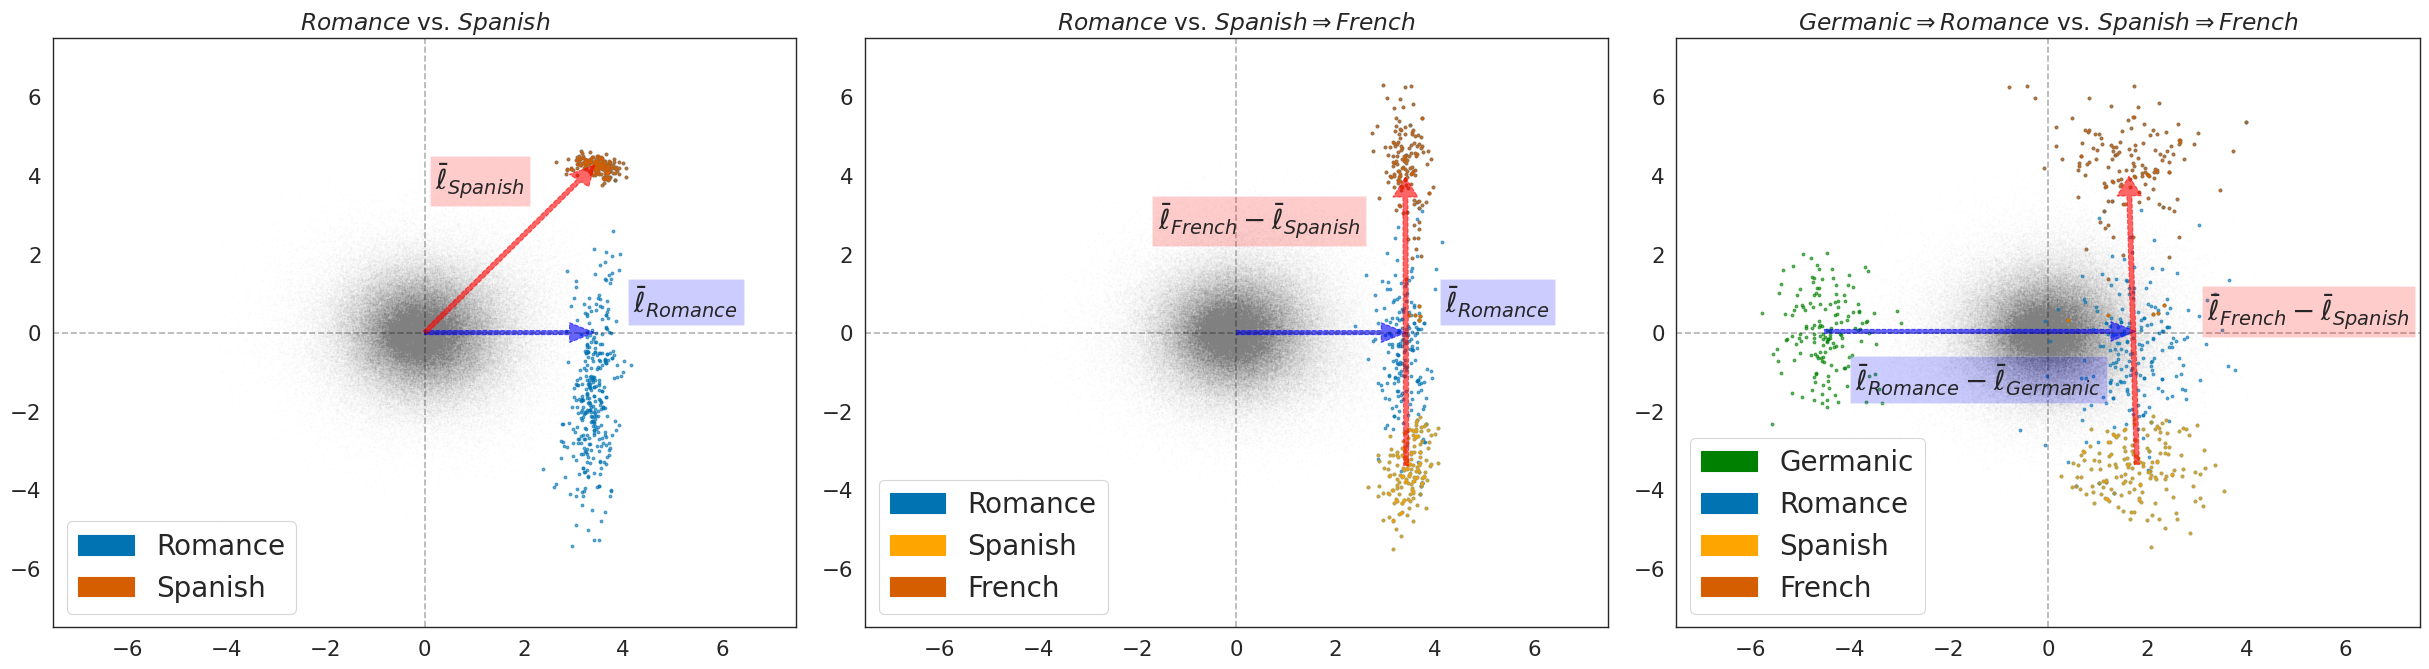

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(25,7))

inds0 = {"Romance": hrc.category_to_indices(all_r_tokens, vocab_dict),
        "Spanish": hrc.category_to_indices(r_token["Spanish"], vocab_dict)}
dir1 = dirs["Romance"]["lda"]
dir2 = dirs["Spanish"]["lda"]
proj_2d(dir1, dir2, g, vocab_list, axs[0],
            normalize=True,
            orthogonal=True,
            added_inds=inds0, k=200, fontsize=20,
            draw_arrows=True,
            arrow1_name=rf'$\bar{{\ell}}_{{Romance}}$',
            arrow2_name=rf'$\bar{{\ell}}_{{Spanish}}$',
            alpha = 0.03,  s = 0.05,
            target_alpha=0.6, target_s=4,
            xlim = (-7.5,7.5), ylim = (-7.5,7.5),
            left_topk = False, bottom_topk = False,
            right_topk = False, top_topk = False,
            xlabel = "", ylabel="",
            title=rf'$Romance$ vs. $Spanish$')

inds1 = {"Romance": hrc.category_to_indices(all_r_tokens, vocab_dict),
        "Spanish": hrc.category_to_indices(r_token["Spanish"], vocab_dict),
        "French": hrc.category_to_indices(r_token["French"], vocab_dict)}

higher = dirs["Romance"]["lda"]
subcat1 = dirs["Spanish"]["lda"]
subcat2 = dirs["French"]["lda"]

proj_2d_single_diff(higher, subcat1, subcat2,
                        g, vocab_list, axs[1],
                        normalize = True,
                        orthogonal = True,
                        added_inds=inds1, k = 50, fontsize= 20,
                        draw_arrows= True,
                        arrow1_name=rf'$\bar{{\ell}}_{{Romance}}$',
                        arrow2_name=rf'$\bar{{\ell}}_{{French}} - \bar{{\ell}}_{{Spanish}}$',
                        alpha = 0.03,  s = 0.05,
                        target_alpha=0.6, target_s=4,
                        xlim = (-7.5,7.5), ylim = (-7.5,7.5),
                        right_topk = False,
                        left_topk = False,
                        top_topk = False,
                        bottom_topk = False,
                        xlabel = "", ylabel="",
                        title = rf'$Romance$ vs. $Spanish \Rightarrow French$')

inds2 = {"Germanic": hrc.category_to_indices(germanic_token, vocab_dict),
        "Romance": hrc.category_to_indices(all_r_tokens, vocab_dict),
        "Spanish": hrc.category_to_indices(r_token["Spanish"], vocab_dict),
        "French": hrc.category_to_indices(r_token["French"], vocab_dict)}

higher1 = dirs_germanic["lda"]
higher2 = dirs["Romance"]["lda"]
subcat1 = dirs["Spanish"]["lda"]
subcat2 = dirs["French"]["lda"]

proj_2d_double_diff(higher1, higher2, subcat1, subcat2,
                        g, vocab_list, axs[2],
                        normalize = True,
                        orthogonal = True,
                        added_inds=inds2, k = 50, fontsize= 20,
                        draw_arrows= True,
                        arrow1_name=rf'$\bar{{\ell}}_{{Romance}} - \bar{{\ell}}_{{Germanic}}$',
                        arrow2_name=rf'$\bar{{\ell}}_{{French}} - \bar{{\ell}}_{{Spanish}}$',
                        alpha = 0.03,  s = 0.05,
                        target_alpha=0.6, target_s=4,
                        xlim = (-7.5,7.5), ylim = (-7.5,7.5),
                        right_topk = False,
                        left_topk = False,
                        top_topk = False,
                        bottom_topk = False,
                        xlabel = "", ylabel="",
                        title = rf'$Germanic \Rightarrow Romance$ vs. $Spanish \Rightarrow French$')

fig.tight_layout()
fig.savefig(f"figures/three_2d_plots_rom_nouns.png", dpi=300, bbox_inches='tight')
fig.show()

In [6]:
cat1 = "Spanish"
cat2 = "French"
cat3 = "Portuguese"
cat4 = "Italian"

dir1 = dirs[cat1]["lda"]
dir2 = dirs[cat2]["lda"]
dir3 = dirs[cat3]["lda"]
dir4 = dirs[cat4]["lda"]

xaxis = (dir2 - dir1) / (dir2-dir1).norm()
yaxis = dir3 - dir1 - (dir3-dir1) @ xaxis * xaxis
yaxis = yaxis / yaxis.norm()
zaxis = (dir4 - dir1) - (dir4 - dir1) @ xaxis * xaxis - (dir4 - dir1) @ yaxis * yaxis
zaxis = zaxis / zaxis.norm()

axes = torch.stack([xaxis, yaxis, zaxis], dim=1)

ind1 = hrc.category_to_indices(r_token["Spanish"], vocab_dict)
ind2 = hrc.category_to_indices(r_token["French"], vocab_dict)
ind3 = hrc.category_to_indices(r_token["Portuguese"], vocab_dict)
ind4 = hrc.category_to_indices(r_token["Italian"], vocab_dict)

g1 = g[ind1]
g2 = g[ind2]
g3 = g[ind3]
g4 = g[ind4]

proj1 = (g1 @ axes).cpu().numpy()
proj2 = (g2 @ axes).cpu().numpy()
proj3 = (g3 @ axes).cpu().numpy()
proj4 = (g4 @ axes).cpu().numpy()
proj = (g @ axes).cpu().numpy()

P1 = (dir1 @ axes).cpu().numpy()
P2 = (dir2 @ axes).cpu().numpy()
P3 = (dir3 @ axes).cpu().numpy()
P4 = (dir4 @ axes).cpu().numpy()

P1 = np.array(P1)
P2 = np.array(P2)
P3 = np.array(P3)
P4 = np.array(P4)

d12 = np.linalg.norm(P2 - P1)
d13 = np.linalg.norm(P3 - P1)
d14 = np.linalg.norm(P4 - P1)
d23 = np.linalg.norm(P3 - P2)
d24 = np.linalg.norm(P4 - P2)
d34 = np.linalg.norm(P4 - P3)

print("Length of side P1-P2 (Spanish-French):", d12)
print("Length of side P1-P3 (Spanish-Portuguese):", d13)
print("Length of side P1-P4 (Spanish-Italian):", d14)
print("Length of side P2-P3 (French-Portuguese):", d23)
print("Length of side P2-P4 (French-Italian):", d24)
print("Length of side P3-P4 (Portuguese-Italian):", d34)

Length of side P1-P2 (Spanish-French): 7.333469
Length of side P1-P3 (Spanish-Portuguese): 6.904065
Length of side P1-P4 (Spanish-Italian): 7.5231647
Length of side P2-P3 (French-Portuguese): 7.6047244
Length of side P2-P4 (French-Italian): 8.240101
Length of side P3-P4 (Portuguese-Italian): 7.9124165


## 3D Plots

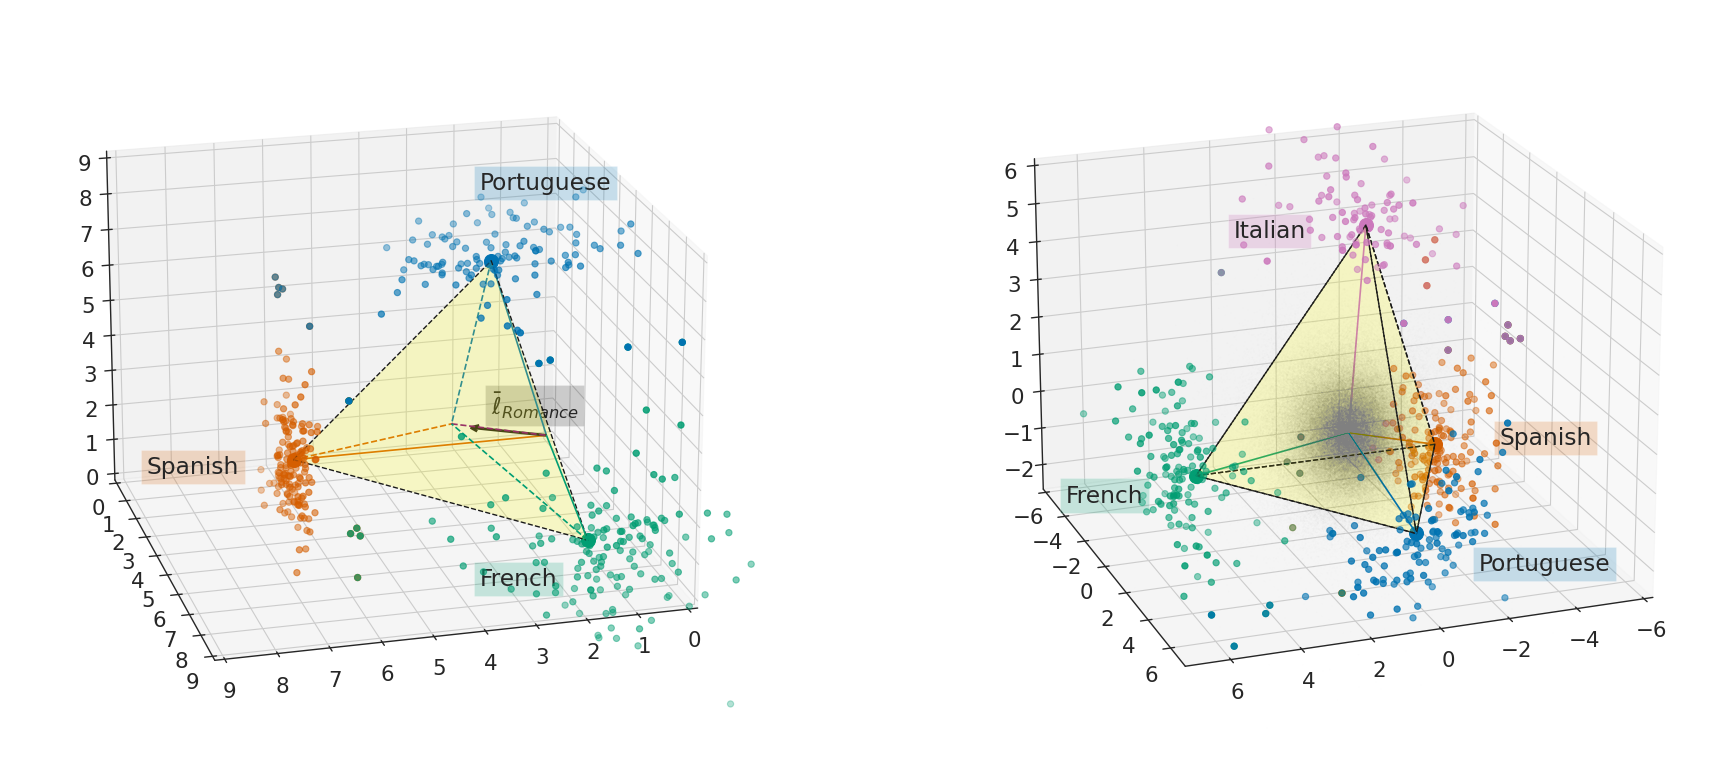

In [7]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121, projection='3d')

cat1 = "Spanish"
cat2 = "French"
cat3 = "Portuguese"

dir1 = dirs[cat1]["lda"]
dir2 = dirs[cat2]["lda"]
dir3 = dirs[cat3]["lda"]
higher_dir = dirs["Romance"]["lda"]

xaxis = dir1 / dir1.norm()
yaxis = dir2 - (dir2 @ xaxis) * xaxis
yaxis = yaxis / yaxis.norm()
zaxis = dir3 - (dir3 @ xaxis) * xaxis - (dir3 @ yaxis) * yaxis
zaxis = zaxis / zaxis.norm()

axes = torch.stack([xaxis, yaxis, zaxis], dim=1)

ind1 = hrc.category_to_indices(r_token["Spanish"], vocab_dict)
ind2 = hrc.category_to_indices(r_token["French"], vocab_dict)
ind3 = hrc.category_to_indices(r_token["Portuguese"], vocab_dict)

g1 = g[ind1]
g2 = g[ind2]
g3 = g[ind3]

proj1 = (g1 @ axes).cpu().numpy()
proj2 = (g2 @ axes).cpu().numpy()
proj3 = (g3 @ axes).cpu().numpy()
proj = (g @ axes).cpu().numpy()

P1 = (dir1 @ axes).cpu().numpy()
P2 = (dir2 @ axes).cpu().numpy()
P3 = (dir3 @ axes).cpu().numpy()
P4 = (higher_dir @ axes).cpu().numpy()

ax.scatter(P1[0], P1[1], P1[2], color='r', s=100)
ax.scatter(P2[0], P2[1], P2[2], color='g', s=100)
ax.scatter(P3[0], P3[1], P3[2], color='b', s=100)

verts = [list(zip([P1[0], P2[0], P3[0]], [P1[1], P2[1], P3[1]], [P1[2], P2[2], P3[2]]))]
triangle = Poly3DCollection(verts, alpha=.2, linewidths=1, linestyle =  "--", edgecolors='k')
triangle.set_facecolor('yellow')
ax.add_collection3d(triangle)

ax.quiver(0, 0, 0, P1[0], P1[1], P1[2], color='r', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P2[0], P2[1], P2[2], color='g', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P3[0], P3[1], P3[2], color='b', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P4[0], P4[1], P4[2], color='k', arrow_length_ratio=0.1, linewidth=2)


scatter1 = ax.scatter(proj1[:,0], proj1[:,1], proj1[:,2], c='r', label=cat1)
scatter2 = ax.scatter(proj2[:,0], proj2[:,1], proj2[:,2], c='g', label=cat2)
scatter3 = ax.scatter(proj3[:,0], proj3[:,1], proj3[:,2], c='b', label=cat3)
scatter = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c='gray', s= 0.05, alpha = 0.00)

scale = 1.2
ax.text(P1[0]*scale + 2, P1[1]* scale, P1[2]*scale, cat1, bbox=dict(facecolor='r', alpha=0.2))
ax.text(P2[0]*scale+2.5, P2[1]* scale+0.5, P2[2]*scale, cat2, bbox=dict(facecolor='g', alpha=0.2))
ax.text(P3[0]*scale, P3[1]* scale, P3[2]*scale+1, cat3, bbox=dict(facecolor='b', alpha=0.2))
ax.text(P4[0]-0.6, P4[1]-0.6, P4[2], rf'$\bar{{\ell}}_{{Romance}}$', bbox=dict(facecolor='k', alpha=0.2))

normal_vector = np.cross(P2 - P1, P3 - P1)
normal_vector = normal_vector / np.linalg.norm(normal_vector)
normal_mag = P1 @ normal_vector
normal_vector = normal_vector * normal_mag

P1_normal = P1 - normal_vector
P2_normal = P2 - normal_vector
P3_normal = P3 - normal_vector

ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P1_normal[0], P1_normal[1], P1_normal[2],
          color='r', linestyle =  "--", arrow_length_ratio=0.01)
ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P2_normal[0], P2_normal[1], P2_normal[2],
          color='g', linestyle =  "--", arrow_length_ratio=0.01)
ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P3_normal[0], P3_normal[1], P3_normal[2],
          color='b', linestyle =  "--", arrow_length_ratio=0.01)

ax.quiver(0, 0, 0, normal_vector[0], normal_vector[1], normal_vector[2], color='purple',
          linestyle =  "--", arrow_length_ratio=0.01)


ax.set_xlim(0, 9)
ax.set_ylim(0, 9)
ax.set_zlim(0, 9)

ax.view_init(elev=20, azim=75)




### Second Plot
ax = fig.add_subplot(122, projection='3d')
cat1 = "Spanish"
cat2 = "French"
cat3 = "Portuguese"
cat4 = "Italian"

dir1 = dirs[cat1]["lda"]
dir2 = dirs[cat2]["lda"]
dir3 = dirs[cat3]["lda"]
dir4 = dirs[cat4]["lda"]

xaxis = (dir2 - dir1) / (dir2-dir1).norm()
yaxis = dir3 - dir1 - (dir3-dir1) @ xaxis * xaxis
yaxis = yaxis / yaxis.norm()
zaxis = (dir4 - dir1) - (dir4 - dir1) @ xaxis * xaxis - (dir4 - dir1) @ yaxis * yaxis
zaxis = zaxis / zaxis.norm()

axes = torch.stack([xaxis, yaxis, zaxis], dim=1)

ind1 = hrc.category_to_indices(r_token["Spanish"], vocab_dict)
ind2 = hrc.category_to_indices(r_token["French"], vocab_dict)
ind3 = hrc.category_to_indices(r_token["Portuguese"], vocab_dict)
ind4 = hrc.category_to_indices(r_token["Italian"], vocab_dict)

g1 = g[ind1]
g2 = g[ind2]
g3 = g[ind3]
g4 = g[ind4]

proj1 = (g1 @ axes).cpu().numpy()
proj2 = (g2 @ axes).cpu().numpy()
proj3 = (g3 @ axes).cpu().numpy()
proj4 = (g4 @ axes).cpu().numpy()
proj = (g @ axes).cpu().numpy()

P1 = (dir1 @ axes).cpu().numpy()
P2 = (dir2 @ axes).cpu().numpy()
P3 = (dir3 @ axes).cpu().numpy()
P4 = (dir4 @ axes).cpu().numpy()

ax.scatter(P1[0], P1[1], P1[2], color='r', s=100)
ax.scatter(P2[0], P2[1], P2[2], color='g', s=100)
ax.scatter(P3[0], P3[1], P3[2], color='b', s=100)
ax.scatter(P4[0], P4[1], P4[2], color='m', s=100)

verts1 = [list(zip([P1[0], P2[0], P3[0]], [P1[1], P2[1], P3[1]], [P1[2], P2[2], P3[2]]))]
triangle1 = Poly3DCollection(verts1, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle1.set_facecolor('yellow')
ax.add_collection3d(triangle1)

verts2 = [list(zip([P1[0], P2[0], P4[0]], [P1[1], P2[1], P4[1]], [P1[2], P2[2], P4[2]]))]
triangle2 = Poly3DCollection(verts2, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle2.set_facecolor('yellow')
ax.add_collection3d(triangle2)

verts3 = [list(zip([P1[0], P3[0], P4[0]], [P1[1], P3[1], P4[1]], [P1[2], P3[2], P4[2]]))]
triangle3 = Poly3DCollection(verts3, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle3.set_facecolor('yellow')
ax.add_collection3d(triangle3)

verts4 = [list(zip([P2[0], P3[0], P4[0]], [P2[1], P3[1], P4[1]], [P2[2], P3[2], P4[2]]))]
triangle4 = Poly3DCollection(verts4, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle4.set_facecolor('yellow')
ax.add_collection3d(triangle4)


ax.quiver(0, 0, 0, P1[0], P1[1], P1[2], color='r', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P2[0], P2[1], P2[2], color='g', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P3[0], P3[1], P3[2], color='b', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P4[0], P4[1], P4[2], color='m', arrow_length_ratio=0.01)


scatter1 = ax.scatter(proj1[:,0], proj1[:,1], proj1[:,2], c='r', label=cat1)
scatter2 = ax.scatter(proj2[:,0], proj2[:,1], proj2[:,2], c='g', label=cat2)
scatter3 = ax.scatter(proj3[:,0], proj3[:,1], proj3[:,2], c='b', label=cat3)
scatter4 = ax.scatter(proj4[:,0], proj4[:,1], proj4[:,2], c='m', label=cat4)
scatter = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c='gray', s= 0.05, alpha = 0.02)


scale = 1.4
scale2 = 1.2
ax.text(P1[0]*scale-1, P1[1]* scale, P1[2]*scale, cat1, bbox=dict(facecolor='r', alpha=0.2))
ax.text(P2[0]*scale+2.1, P2[1]* scale, P2[2]*scale, cat2, bbox=dict(facecolor='g', alpha=0.2))
ax.text(P3[0]*scale-1, P3[1]* scale, P3[2]*scale, cat3, bbox=dict(facecolor='b', alpha=0.2))
ax.text(P4[0]*scale2+4, P4[1]* scale2, P4[2]*scale2-1, cat4, bbox=dict(facecolor='m', alpha=0.25))

ax.set_xlim(-6,7)
ax.set_ylim(-6,7)
ax.set_zlim(-2.5, 6)

ax.view_init(elev=20, azim=70)

#fig.suptitle('Romance Nouns', fontsize=26)
plt.tight_layout()
fig.savefig(f"figures/two_3D_plots_rom_nouns.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
num_tokens_cat1 = len(ind1)
num_tokens_cat2 = len(ind2)
num_tokens_cat3 = len(ind3)
num_tokens_cat4 = len(ind4)

print(f"Number of tokens in {cat1}: {num_tokens_cat1}")
print(f"Number of tokens in {cat2}: {num_tokens_cat2}")
print(f"Number of tokens in {cat3}: {num_tokens_cat3}")
print(f"Number of tokens in {cat4}: {num_tokens_cat4}")

Number of tokens in Spanish: 164
Number of tokens in French: 142
Number of tokens in Portuguese: 116
Number of tokens in Italian: 97
